# Siamese LSTM

This notebook serves as an example on how a Siamese LSTM Neural Network can be implemented to analyse semantic similarity.

In [1]:
import os
import pandas as pd
import numpy as np
import wandb

import torch
import torch.nn as nn

## NLP DATA PREPROCESSING

In [2]:
import re
import nltk 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

def text_to_wordlist(text, remove_stopwords, stem_words):
    """ 
    This function was adapoted from 
    https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
    
    Description:
        - Clean the text, with the option to remove stopwords and to stem words.
        - Convert words to lower case and split them 
    
    Params:
    -------
    text : str
           question string 
    remove_stopwords : bool
                       if True --> removes stopwords, if False --> does not remove stopwords 
    stem_words : bool
                 if True --> stem stopwords, if False --> normal
    
    return:
    -------
    text : str
           cleaned questing string 
    """
    text = text.lower().split()  # split tokenize sentence into words

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)  # other than the mentioned things(^) will replaced by space
    text = re.sub(r"what's", "what is ", text)  # what's replaced by what is
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    text = text.strip()
    return text

In [3]:
def convert_data_to_tuples(df, remove_stopwords, stem_words):
    questions_pair = []
    labels = []
    for _, row in df.iterrows():

        q1 = text_to_wordlist(str(row['question1']), remove_stopwords, stem_words)
        q2 = text_to_wordlist(str(row['question2']), remove_stopwords, stem_words)
        label = int(row['is_duplicate'])
        if q1 and q2:
            questions_pair.append((q1, q2))
            labels.append(label)

    print ('Question Pairs: ', len(questions_pair))
    return questions_pair, labels

In [4]:
class Language:
    def __init__(self):
        """ 
        Language class keeps track of the datasets vocabulary and creates 
        a words to index dictionary that will be required in the pytroch dataset
        """
        self.word2index = {}  # sets index accodringly to unique ness - most common lower index e.g.1 
        self.word2count = {}  # counts each unique word 
        self.index2word = {}  # reverse of word3index
        self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words + 1
            self.word2count[word] = 1
            self.index2word[self.n_words + 1] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Pytorch Dataset

In [5]:
from torch.utils.data import Dataset

class QuoraDataset(Dataset):
    def __init__(self, questions_list, word2index, labels):
        """
        Params:
        -------
        questions_list : list
                         list with tuples of all the questions pairs 
        
        word2index : dict
                     vocbulary of the dataset
        labels : list 
                 list of the corrsponding labels to the question pairs 
        
        """
        self.questions_list = questions_list
        self.labels = labels
        self.word2index = word2index
        
    def __len__(self):
        return len(self.questions_list)
    
    def __getitem__(self, index):
        questions_pair = self.questions_list[index]
        q1 = questions_pair[0]
        q1_indices = []
        for word in q1.split():
            q1_indices.append(self.word2index[word])
            
        q2 = questions_pair[1]
        q2_indices = []
        for word in q2.split():
            q2_indices.append(self.word2index[word])
            
        # q1_indices and q2_indices are lists of indices against words used in the sentence 
        return {
            'q1': q1,
            'q2': q2,
            'q1_token': q1_indices, 
            'q2_token': q2_indices, 
            'labels': self.labels[index], 
        }

In [6]:
def collate(batch):
    q1_text_list = []
    q2_text_list = []
    q1_list = []
    q2_list = []
    labels = []
    for item in batch:
        q1_text_list.append(item['q1'])
        q2_text_list.append(item['q2'])
        q1_list.append(item['q1_token'])
        q2_list.append(item['q2_token'])
        labels.append(item['labels'])
          
        
    q1_lengths = [len(q) for q in q1_list]
    q2_lengths = [len(q) for q in q2_list]
    
    return {
        'q1_text': q1_text_list,
        'q2_text': q2_text_list, 
        'q1_token': q1_list, 
        'q2_token': q2_list,
        'q1_lengths': q1_lengths, 
        'q2_lengths': q2_lengths,
        'labels': labels
    }

## Create pretrained weights for model initialization

In [28]:
import gensim
import gensim.downloader as api

glove_dir = os.getcwd() + '/glove.6B'

wv = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    wv[word]= coefs
f.close()

def create_pretrained_weights(embedding_dim, language):
    """ Load pretrained weight and create pretrained weights for the embedding layer of the model from pre-trained embeddings """
    n_words_vocab = len(language.word2index)
    
    # Initialize a weights matrix with random values
    weights = torch.randn(n_words_vocab + 1, embedding_dim)
    weights[0] = torch.zeros(embedding_dim)  # zero vector for padding
    
    for word, lang_word_index in language.word2index.items():
        if word in wv:  # check if word is in the GloVe dictionary
            weights[lang_word_index] = torch.FloatTensor(wv[word])  # update the weights matrix with the GloVe vector
    
    return weights

In [29]:
import torch.nn as nn
from torch.nn.modules import dropout
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import numpy as np

class EmbeddingLSTMNet(nn.Module):
    def __init__(
            self,
            embedding_dim,
            hidden_cells,
            num_layers, 
            embedding_rquires_grad,
            pretrained_weights,
            dropout,
            simple,
            ):
        super(EmbeddingLSTMNet, self).__init__()
        """ 
        LSTM Network and embeddings from pretrained weights
        
            - 1 lstm is enough since weights are shared
        embedding_dim : int
                        embedding dimnesion
        hidden_cells : int 
                       number of hidden cells in LSTM
        num_layers :  int
                      number of layers
        embedding_requires_grad : bool
        pretrained_weights : torch.tensor
                             pre-trained weights tensor 
        dropout : float
                  indicates the dropout percentage
        simple : bool
                 selects the simplest model, only LSTM layer
        """
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_cells, 
            num_layers=num_layers, 
            batch_first=True
        )
        self.fc1 = nn.Linear(hidden_cells, hidden_cells)
        self.fc = nn.Linear(hidden_cells, hidden_cells)
        self.relu = nn.ReLU()
        # initialize embeddings 
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights)
        self.embedding.weight.requires_grad = embedding_rquires_grad

        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = 'cpu'
        self.simple = simple

    def forward(self, question, lengths):
        """ 
        Params:
        -------
        question : (batch dim, sequence) # Question ke words ka index ek batch ka yaha 31 ka batch h
                   i.e. [ [i1, i2, i3], -------- Q1[0]
                          [j1, j2, j4, j5] ] --- Q1[1]
        lenghts : list
                  list all the lengths of each question  
        
        Return:
        -------
        result : torch.tensor
                 output tesnor of of forward pass 
        """
        # Reverse the sequence lengths indices in decreasing order (pytorch requirement for pad and pack)
        sorted_indices = np.flipud(np.argsort(lengths))
        lengths = np.flipud(np.sort(lengths))
        lengths = lengths.copy()
        
        # Reorder questions in the decreasing order of their lengths
        ordered_questions = [torch.LongTensor(question[i]).to(self.device) for i in sorted_indices]
        # Pad sequences with 0s to the max length sequence in the batch
        ordered_questions = pad_sequence(ordered_questions, batch_first=True)
        # Retrieve Embeddings
        embeddings = self.embedding(ordered_questions).to(self.device)
        
        
        # Model forward 
        embeddings = self.dropout(embeddings)
        # Pack the padded sequences and pass it through LSTM
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)   # Explained below
        out, (hn, cn) = self.lstm(packed)
        # Unpack the padded sequence and pass it through the linear layers 
        unpacked, unpacked_len = pad_packed_sequence(out, batch_first=True, total_length=int(lengths[0]))
        
        if self.simple == False:
            out = self.fc1(unpacked)
            out = self.relu(out)
            out = self.fc(out)
        else:
            out = unpacked
        
        # Reorder the output to the original order in which the questions were passed
        result = torch.FloatTensor(out.size())
        for i, encoded_matrix in enumerate(out):
            result[sorted_indices[i]] = encoded_matrix
        return result

In [30]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_lstm_net):
        super(SiameseNetwork, self).__init__()
        """
        Siamese LSTM Network 

        Params:
        -------
        embedding_lstm_net : nn.Module
                             embedded LSTM Network 
        """
        self.embedding = embedding_lstm_net
        
        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = 'cpu'
        
    def forward(self, q1, q2, q1_lengths, q2_lengths):
        """ Forward pass 
        Params:
        -------
        q1 : pad sequence tensor 
             question 1  
        q2 : pad sequence tensor 
             question 2  
        q1_lengths : torch.tensor
                      original lengths of each question 1
        q2_lengths : torch.tensor
                      original lengths of each question 1
        Returns:
        --------
        similarity_score : torch.tensor
        """
        output_q1 = self.embedding(q1, q1_lengths)
        output_q2 = self.embedding(q2, q2_lengths)
        similarity_score = torch.zeros(output_q1.size()[0]).to(self.device)
        # Calculate Similarity Score between both questions in a single pair
        for index in range(output_q1.size()[0]):
            # Sequence lenghts are being used to index and retrieve the activations before the zero padding since they were not part of original question
            q1 = output_q1[index, q1_lengths[index] - 1, :]
            q2 = output_q2[index, q2_lengths[index] - 1, :]
            similarity_score[index] = self.manhattan_distance(q1, q2)
        
        return similarity_score
    
    def manhattan_distance(self, q1, q2):
        """ Computes the Mannhatten distance between the two question tokens """
        return torch.exp(-torch.sum(torch.abs(q1 - q2), dim=0)).to(self.device)

The expression output_q1[index, q1_lengths[index] - 1, :] is not slicing from that index to the end of the vector. Instead, it's selecting a specific row from a 3D tensor. Let's break down the expression for clarity:

output_q1 is a 3D tensor, where its dimensions could be represented as [batch_size, sequence_length, embedding_dimension].
index specifies which element in the batch we are considering.
q1_lengths[index] - 1 specifies the index of the last non-padded word in the sequence for the index-th element in the batch. This is because q1_lengths[index] gives the length of the sequence, and subtracting 1 adjusts for 0-indexing.
: specifies that we want all elements along the embedding dimension.
So, output_q1[index, q1_lengths[index] - 1, :] is selecting the embedding of the last non-padded word for the index-th element in the batch. It's a vector, not a slice of vectors.

In [31]:
from typing import Coroutine
from tqdm import tqdm
import time 
import wandb

from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

class ModelTrainer:
    def __init__(self, model, hparams, train_dataloader, val_dataloader, 
        train_indices, val_indices, log_to_wandb, lr_scheduler_enabler=True):
        """ 
        This Class fits the model 

        Params:
        -------  
        model : nn.Module
                Pytorch NN Model that is spposed to be fitted/trained
        hparams : dict
                  Dictionary of Hyperparametes  
        train_dataloader : torch.utils.data.DataLoader
                           Training DataLoader
        val_dataloader : torch.utils.data.DataLoader
                         Validation DataLoader 
        train_indices : list 
                        list of the train indices
        val_indices : list
                      list of the val indices 
        lr_scheduler_enabler : bool
                               if True enables Learning rate scheduler, if False disables it
        """
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.lr_scheduler_enabler = lr_scheduler_enabler
        self.hparams = hparams 
        self.learning_rate = hparams['learning_rate']
        self.epochs = hparams['epoch']
        self.train_indices = train_indices
        self.val_indices = val_indices
        self.log_to_wandb = log_to_wandb

        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = 'cpu'
        if self.device == "cuda":
            self.threshold = hparams['threshold'].to(self.device)
        else:
            self.threshold = hparams['threshold'].to(self.device)

        self.model = model
        self.optimizer = self.optimization()
        self.loss_fn = self.loss()
        self.lr_scheduler = self.learning_rate_scheduler() 

        self.data = dict()
        self.data["train_loss"] = list()
        self.data["train_acc"] = list()
        self.data["val_loss"] = list()
        self.data["val_acc"] = list()

        if self.log_to_wandb:
            self.init_wandb()


    def train_epoch(self, epoch):
        """ Trains an epoch """
        self.model.train()

        loss_history = []
        correct_total = 0
        with tqdm(self.train_dataloader, unit="batch") as tepoch:
            for i, batch in enumerate(tepoch):
                tepoch.set_description(f"Epoch [{epoch+1}/{self.epochs}]  Training")
                if self.device == "cuda":
                    q1, q2 = batch['q1_token'].to(self.device), batch['q2_token'].to(self.device)
                    q1_len, q2_len = batch['q1_lengths'].to(self.device), batch['q2_lengths'].to(self.device)
                    y = torch.FloatTensor(batch['labels']).to(self.device)
                else:
                    q1, q2 = batch['q1_token'], batch['q2_token']
                    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
                    y = torch.FloatTensor(batch['labels'])
                
                # Reset the gardients 
                self.optimizer.zero_grad()

                # Model forward and predictions
                similarity = self.model(q1, q2, q1_len, q2_len)
                y_pred = (similarity > self.threshold).float() * 1
                correct = self.inferece(y_pred, y)
                correct_total += correct

                # Calculate the loss 
                loss = self.loss_fn(similarity, y)
                loss_history.append(loss.item())

                # Calculate gradients by performign the backward pass
                loss.backward()
                
                # Update weights
                self.optimizer.step()

                if i % 100 == 0:
                    tepoch.set_postfix(train_loss=np.mean(loss_history), train_acc=f'{(correct/y.size()[0])*100} %' )
            
            # Enable learning rate scheduler  
            if self.lr_scheduler_enabler:
                self.lr_scheduler.step()

        return  np.mean(loss_history), (correct_total/len(self.train_indices))*100

    def evaluate(self):
        """ Validates an epoch """
        self.model.eval()

        loss_history = []
        correct_total = 0
        with torch.no_grad():
            for i, batch in enumerate(self.val_dataloader):
                if self.device == "cuda":
                    q1, q2 = batch['q1_token'].to(self.device), batch['q2_token'].to(self.device)
                    q1_len, q2_len = batch['q1_lengths'].to(self.device), batch['q2_lengths'].to(self.device)
                    y = torch.FloatTensor(batch['labels']).to(self.device)
                else:
                    q1, q2 = batch['q1_token'], batch['q2_token']
                    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
                    y = torch.FloatTensor(batch['labels'])

                # Model forward and predictions
                similarity = self.model(q1, q2, q1_len, q2_len)
                y_pred = (similarity > self.threshold).float() * 1
                correct = self.inferece(y_pred, y)
                correct_total += correct

                # Calculate the loss 
                loss = self.loss_fn(similarity, y)
                loss_history.append(loss.item())

        avg_val_acc =  correct_total/len(self.val_indices) * 100 
        return np.mean(loss_history), avg_val_acc
    
    def inferece(self, y_pred, y):
        """ Performs inference """
        return (y_pred == y).sum().item()

    def fit(self):
        """ Fits the model """
        train_loss = 0
        val_loss = 0
        val_acc = 0
        for e in range(self.epochs):
            train_loss, train_acc = self.train_epoch(e)
            val_loss, val_acc = self.evaluate()
            print(f'Epoch [{e+1}/{self.epochs}] Validation: val_loss: {val_loss} val_acc: {val_acc} %')
            
            self.data["train_loss"].append(train_loss)
            self.data["train_acc"].append(train_acc)
            self.data["val_loss"].append(val_loss)
            self.data["val_acc"].append(val_acc)

            if self.log_to_wandb:
                self.log_metrics_to_wandb(train_loss, train_acc, val_loss, val_acc)
            time.sleep(0.5)

        if self.log_to_wandb:
            wandb.finish()

    def test(self):
        """ Tests the model """
        self.model.eval()

        predictions = []
        labels_list = []
        loss_history = []
        correct_total = 0
        with torch.no_grad():
            for i, batch in enumerate(self.val_dataloader):
                if self.device == "cuda":
                    q1, q2 = batch['q1_token'].to(self.device), batch['q2_token'].to(self.device)
                    q1_len, q2_len = batch['q1_lengths'].to(self.device), batch['q2_lengths'].to(self.device)
                    y = torch.FloatTensor(batch['labels']).to(self.device)
                else:
                    q1, q2 = batch['q1_token'], batch['q2_token']
                    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
                    y = torch.FloatTensor(batch['labels'])

                # Model forward and predictions
                similarity = self.model(q1, q2, q1_len, q2_len)
                y_pred = (similarity > self.threshold).float() * 1
                predictions.append(y_pred), labels_list.append(y)
                correct = self.inferece(y_pred, y)
                correct_total += correct

                # Calculate the loss 
                loss = self.loss_fn(similarity, y)
                loss_history.append(loss.item())
        
        # Calculate the accuracy
        avg_val_acc =  correct_total/len(self.val_indices) * 100 
        print('- - - Model Performance - - -')
        print(f'\nModel Accuracy:  {avg_val_acc}')
        print(f'Correct predictions: {correct_total}, Incorret predictions: {len(self.val_indices) - correct_total}')
        print('')
        cm = plotConfusionMatrix(np.hstack(predictions), np.hstack(labels_list),['similar', 'dissimilar'], title="Confusion Matrix Plot of Test Set")
        print(f'TP: {cm[0,0]}')
        print(f'FP: {cm[1,0]}')
        print(f'FN: {cm[0,1]}')
        print(f'TN: {cm[1,1]}')
        print(f'\nPrecision Score: {precision_score(np.hstack(predictions), np.hstack(labels_list))}')
        print(f'Recall Score: {recall_score(np.hstack(predictions), np.hstack(labels_list))}')
        print(f'F1 Score: {f1_score(np.hstack(predictions), np.hstack(labels_list))}')

        # adopted from https://www.codegrepper.com/code-examples/python/roc+curve+pytorch
        fpr, tpr, threshold = roc_curve(np.hstack(predictions), np.hstack(labels_list))
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.grid()
        plt.show()
        # adopted from https://www.codegrepper.com/code-examples/python/roc+curve+pytorch

    def predict(self, test_sample_dict):
        """ Uses the model to predict the similarity of a given input pair of questions"""
        self.model.eval()
        
        print('question 1:', test_sample_dict['q1_text'])
        print('question 2:', test_sample_dict['q2_text'])
        print('tokens  q1:', test_sample_dict['q1_token'])
        print('tokens  q2:', test_sample_dict['q2_token'])

        q1, q2 = test_sample_dict['q1_token'], test_sample_dict['q2_token']
        q1_len, q2_len = test_sample_dict['q1_lengths'], test_sample_dict['q2_lengths']
        y = torch.FloatTensor(test_sample_dict['labels'])
        
        # Model forward and predictions
        similarity = self.model(q1, q2, q1_len, q2_len)
        y_pred = (similarity > self.threshold).float() * 1
        
        print(f'\n\nModel predicts {y_pred.item()} --> Actual value {y.item()}')
        if y_pred.item() == y.item():
            print(f'Model prediction is correct :)')

            if y_pred.item() == 1.0:
                print(f'\nThe questions {test_sample_dict["q1_text"]} and {test_sample_dict["q2_text"]} are similar!')
            else:
                print(f'\nThe questions {test_sample_dict["q1_text"]} and {test_sample_dict["q2_text"]} are dissimilar!')    
        else:
            print(f'Model prediction is inaccurate :(')
            if y_pred.item() == 1.0:
                print(f'\nThe questions {test_sample_dict["q1_text"]} and {test_sample_dict["q2_text"]} should be dissimilar!')
            else:
                print(f'\nThe questions {test_sample_dict["q1_text"]} and {test_sample_dict["q2_text"]} should be similar!')  
        
    def optimization(self):
        """ Initializes the optimizer """
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def learning_rate_scheduler(self):
        """ Initializes the learning rate scheduler """
        return torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)

    def loss(self):
        """ Initializes the loss """
        return nn.MSELoss() #nn.CrossEntropyLoss()
    
    def return_data(self):
        """ Output the data """
        return self.data

    def init_wandb(self):
        """ init weight & biases """
        # capture hyperparameters
        config = self.hparams
        # initialize wandb
        wandb.init(project="Siamese_LSTM", entity="maxifor", config=config)

    def log_metrics_to_wandb(self, train_loss, train_acc, val_loss, val_acc):
        """ log metric to weights and biases """
        wandb.log({"train_loss": train_loss,})
        wandb.log({"train_acc": train_acc,})
        wandb.log({"val_loss": val_loss,})
        wandb.log({"val_acc": val_acc,})

In [32]:
def save_model(model, path):
    """ Saves a pytorch model locally """
    return torch.save(model.state_dict(), path)

def load_model(model, path):
    """ Loads a model locally """
    m = model(n_classes=10)
    # load the state dict and pass it to the load_state_dict function
    return m.load_state_dict(torch.load("./model.pt"))

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plotConfusionMatrix(y, y_pred, classes, title=None):
    """ Plots a confusion matrix """
    cm = confusion_matrix(y, y_pred)
    ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True, fmt='0.2g', cmap=plt.cm.Blues)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Test Set')
    plt.show()

    return cm

#### Set Global Varibles and Paths 

In [34]:
# Root and directory paths 
ROOT_PATH = os.getcwd()
DATA_FOLDER_PATH = ROOT_PATH + '/data'
MODEL_FOLDER_PATH = ROOT_PATH 
# important paths 
DATASET_FILE_PATH = DATA_FOLDER_PATH + '/mini_quora_dataset_30_50_50k.csv'

# general variables
EMBEDDING_REQUIRES_GRAD = False
NUM_LAYERS = 1

#### Hyperparameters 

In [35]:
# Hyperparameters - adjust them to optimize model perfromance

hparams = {
    'threshold':        torch.Tensor([0.5]),  # Threshold for determining similarity
    'learning_rate':    1e-03,                # Learning rate
    'epoch':            20,                   # Number of epochs
    'batch_size':       32,                   # Batch size
    'hidden_dim':       100,                  # Number of hidden dimensions
    'embedding_dim':    300,                  # Number of embedding dimensions
    'dropout':          0.0,                  # Dropout
    'remove_stopwords': False,                # Removes stopwords
    'stem_words':       False,                # Remove stem words
    'simple':           True,                 # Chooses simple or more complex model
    'log_to_wandb':     False,                # Chooses to log to wandb or not
}

## Prepare the Dataset

#### Load the data

In [36]:
df = pd.read_csv(DATASET_FILE_PATH)

#### Select question pair and labels and prepare the data 

In [37]:
df

,id,qid1,qid2,question1,question2,is_duplicate,max_length
0,307549,603786,603787,What are some different ways to make money fast?,What are fast ways to make money?,1,48
1,221916,437426,437427,How can I continue to improve my English?,How can I understand english?,1,41
2,177830,351280,351281,How do I promote my youtube videos?,What is the best way to promote YouTube videos?,1,47
3,128018,253605,253606,How can I organize a Quora Meetup in Pune?,Is there a Pune Quora Meetup group?,0,42
4,177761,351144,351145,What is the most badass moment of Game of Thro...,Who will die in season 5 of Game of Thrones?,0,50
...,...,...,...,...,...,...,...
49995,95213,189005,189006,How does drop shipping work exactly?,What is drop shipping and how does it work?,1,43
49996,62682,124658,124659,What are the best movies to watch in Hollywood?,Which are the best Hollywood movies of all time?,1,48
49997,109939,218008,218009,"Am I a sociopath, schizoid, or neither?",Am I a sociopath?,0,39
49998,370854,725712,725713,What is your marketing strategy?,What is a market strategy?,0,32


In [38]:
q_pair, labels = convert_data_to_tuples(df, hparams['remove_stopwords'], hparams['stem_words'])

Question Pairs:  49999


In [39]:
type(q_pair[0])

tuple

#### Create a Language

In [40]:
language = Language()
for data in [q_pair]:
    for question_pair in data:
        q1 = question_pair[0]
        q2 = question_pair[1]
        language.addSentence(q1)
        language.addSentence(q2)

In [41]:
# language.word2index

# Vocabulary size = 23019

### Create the PyTorch Dataset

In [42]:
quora_dataset = QuoraDataset(q_pair, language.word2index, labels)
quora_dataset[0]

{'q1': 'what are some different ways to make money fast',
 'q2': 'what are fast ways to make money',
 'q1_token': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'q2_token': [1, 2, 9, 5, 6, 7, 8],
 'labels': 1}

In [43]:
# example output

for sample in quora_dataset:
    print('question 1:', sample['q1'])
    print('question 2:', sample['q2'])
    print('tokens  q1:', sample['q1_token'])
    print('tokens  q2:', sample['q2_token'])
    print('labels    :', sample['labels'])
    break

question 1: what are some different ways to make money fast
question 2: what are fast ways to make money
tokens  q1: [1, 2, 3, 4, 5, 6, 7, 8, 9]
tokens  q2: [1, 2, 9, 5, 6, 7, 8]
labels    : 1


### DataLoader

In [44]:
from torch.utils.data import DataLoader, SubsetRandomSampler

train_split = 0.8
val_split = 0.2

dataset_size = len(quora_dataset)
indices = list(range(dataset_size))

split_train = int(train_split*dataset_size)

shuffle_dataset = True
random_seed = 46

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split_train], indices[split_train:]

assert len(train_indices) + len(val_indices) == dataset_size

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_dataloader = DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=collate)
val_dataloader = DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=collate)

print('Training Set Size {}, Validation Set Size {},'.format(len(train_indices), len(val_indices)))

Training Set Size 39999, Validation Set Size 10000,


## Model 

In [45]:
hparams['embedding_dim']

300

In [46]:
# create pretrained weights 
# instead import the pretrained_weights.pt 
pretrained_weights = create_pretrained_weights(hparams['embedding_dim'], language)
pretrained_weights

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2002,  0.1430,  0.0521,  ...,  0.0349, -0.1260,  0.2186],
        [-0.2359,  0.3831,  0.1083,  ..., -0.7919, -0.0860, -0.1466],
        ...,
        [-0.5166,  0.7838,  0.0148,  ..., -0.0129,  0.1836,  0.1006],
        [ 0.4904,  0.8675, -0.0118,  ..., -0.2880,  0.3661, -0.1484],
        [ 0.0508,  0.4372, -0.0654,  ...,  0.4600,  0.3140,  0.1797]])

### Initialize PyTorch Model

In [47]:
# pretrained_weights = torch.load('pretrained_weights.pt')
pretrained_weights.shape

torch.Size([23020, 300])

In [48]:
# embedding net
embedding_net = EmbeddingLSTMNet(
    hparams['embedding_dim'],
    hparams['hidden_dim'],
    NUM_LAYERS,
    EMBEDDING_REQUIRES_GRAD,
    pretrained_weights,
    hparams['dropout'],
    hparams['simple'], # if simple=True --> simple model, if simple=False --> more complex model (2 linear layers plus relu)
)

# siamese model
model = SiameseNetwork(embedding_net)

In [49]:
# test model class with one batch from the dataloader 
for i, batch in enumerate(train_dataloader):
    q1, q2 = batch['q1_token'], batch['q2_token']
    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
    y = torch.FloatTensor(batch['labels'])

model(q1, q2, q1_len, q2_len)

tensor([6.7791e-02, 2.9077e-04, 2.9350e-02, 7.2936e-05, 3.9264e-05, 4.0210e-03,
        2.2242e-03, 2.6707e-01, 1.0498e-02, 2.5957e-04, 2.1253e-01, 7.9960e-01,
        2.0434e-02, 6.0393e-01, 3.9755e-06, 8.5250e-02, 5.2545e-04, 1.9895e-04,
        1.6110e-01, 2.2574e-03, 1.1940e-01, 5.5427e-02, 7.7315e-04, 8.3851e-01,
        3.6147e-02, 8.8136e-05, 1.2681e-01, 3.0809e-04, 9.7574e-02, 6.2670e-01,
        2.2503e-03], grad_fn=<CopySlices>)

In [50]:
model

SiameseNetwork(
  (embedding): EmbeddingLSTMNet(
    (dropout): Dropout(p=0.0, inplace=False)
    (lstm): LSTM(300, 100, batch_first=True)
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc): Linear(in_features=100, out_features=100, bias=True)
    (relu): ReLU()
    (embedding): Embedding(23020, 300)
  )
)

### Training

In [51]:
# test model class with one batch from the dataloader 
for i, batch in enumerate(train_dataloader):
    q1, q2 = batch['q1_token'], batch['q2_token']
    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
    y = torch.FloatTensor(batch['labels'])

model(q1, q2, q1_len, q2_len)

tensor([1.9857e-04, 1.8477e-02, 1.0000e+00, 1.3020e-03, 4.8890e-03, 5.9350e-02,
        1.9167e-02, 9.4491e-02, 1.3066e-05, 3.4657e-02, 8.6183e-04, 2.2165e-04,
        1.3345e-03, 2.5842e-03, 6.7617e-01, 1.5823e-02, 2.1509e-03, 2.4095e-03,
        7.4527e-04, 2.8658e-01, 1.6983e-01, 3.6502e-03, 1.1083e-03, 5.7088e-05,
        1.6579e-01, 9.5148e-03, 3.4753e-03, 5.2033e-04, 2.7836e-01, 2.7003e-01,
        6.3050e-02], grad_fn=<CopySlices>)

#### Initialize the ModelTrainer

In [52]:
trainer = ModelTrainer(
    model, 
    hparams, 
    train_dataloader, 
    val_dataloader,
    train_indices, 
    val_indices,
    log_to_wandb=hparams['log_to_wandb'],
)

#### Fit the model

In [53]:
trainer.fit()

Epoch [1/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 49.17batch/s, train_acc=62.5 %, train_loss=0.209]  


Epoch [1/20] Validation: val_loss: 0.18191314771914255 val_acc: 73.15 %


Epoch [2/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 49.42batch/s, train_acc=71.875 %, train_loss=0.171]


Epoch [2/20] Validation: val_loss: 0.17287057064497433 val_acc: 74.92999999999999 %


Epoch [3/20]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 47.27batch/s, train_acc=84.375 %, train_loss=0.159]


Epoch [3/20] Validation: val_loss: 0.16893939631053814 val_acc: 75.53999999999999 %


Epoch [4/20]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 48.05batch/s, train_acc=90.625 %, train_loss=0.151]


Epoch [4/20] Validation: val_loss: 0.16620670428005652 val_acc: 75.53 %


Epoch [5/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 49.36batch/s, train_acc=84.375 %, train_loss=0.144]


Epoch [5/20] Validation: val_loss: 0.16378385368913126 val_acc: 75.85 %


Epoch [6/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 49.79batch/s, train_acc=81.25 %, train_loss=0.139] 


Epoch [6/20] Validation: val_loss: 0.16228495535854334 val_acc: 76.33 %


Epoch [7/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 48.78batch/s, train_acc=68.75 %, train_loss=0.134] 


Epoch [7/20] Validation: val_loss: 0.16128365633586725 val_acc: 76.79 %


Epoch [8/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 49.36batch/s, train_acc=81.25 %, train_loss=0.13] 


Epoch [8/20] Validation: val_loss: 0.16027613031787993 val_acc: 76.85 %


Epoch [9/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 48.82batch/s, train_acc=81.25 %, train_loss=0.126] 


Epoch [9/20] Validation: val_loss: 0.1600371053852974 val_acc: 76.99000000000001 %


Epoch [10/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 49.52batch/s, train_acc=84.375 %, train_loss=0.123]


Epoch [10/20] Validation: val_loss: 0.1593981486873124 val_acc: 77.25 %


Epoch [11/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 48.26batch/s, train_acc=87.5 %, train_loss=0.12]   


Epoch [11/20] Validation: val_loss: 0.15925832516469132 val_acc: 77.57 %


Epoch [12/20]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.94batch/s, train_acc=81.25 %, train_loss=0.118]


Epoch [12/20] Validation: val_loss: 0.15896973009117113 val_acc: 77.61 %


Epoch [13/20]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.21batch/s, train_acc=78.125 %, train_loss=0.115]


Epoch [13/20] Validation: val_loss: 0.15874363329654304 val_acc: 77.52 %


Epoch [14/20]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.86batch/s, train_acc=87.5 %, train_loss=0.114]  


Epoch [14/20] Validation: val_loss: 0.15877864400323588 val_acc: 77.49000000000001 %


Epoch [15/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 48.41batch/s, train_acc=87.5 %, train_loss=0.112] 


Epoch [15/20] Validation: val_loss: 0.15849638830263393 val_acc: 77.58 %


Epoch [16/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 49.37batch/s, train_acc=87.5 %, train_loss=0.11]  


Epoch [16/20] Validation: val_loss: 0.15869141969913111 val_acc: 77.61 %


Epoch [17/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 48.95batch/s, train_acc=90.625 %, train_loss=0.109]


Epoch [17/20] Validation: val_loss: 0.15815949082945863 val_acc: 77.66 %


Epoch [18/20]  Training: 100%|██████████| 1250/1250 [00:25<00:00, 48.34batch/s, train_acc=84.375 %, train_loss=0.108]


Epoch [18/20] Validation: val_loss: 0.1581576805764113 val_acc: 77.72 %


Epoch [19/20]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 47.12batch/s, train_acc=96.875 %, train_loss=0.106]


Epoch [19/20] Validation: val_loss: 0.15851952178409687 val_acc: 77.85 %


Epoch [20/20]  Training: 100%|██████████| 1250/1250 [00:29<00:00, 42.79batch/s, train_acc=87.5 %, train_loss=0.106]  


Epoch [20/20] Validation: val_loss: 0.1582862760740728 val_acc: 77.8 %


### Evaluation 

- - - Model Performance - - -

Model Accuracy:  77.8
Correct predictions: 7780, Incorret predictions: 2220



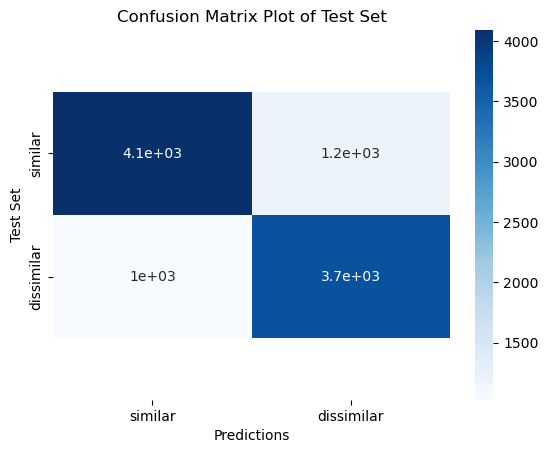

TP: 4090
FP: 1026
FN: 1194
TN: 3690

Precision Score: 0.7555282555282555
Recall Score: 0.7824427480916031
F1 Score: 0.76875


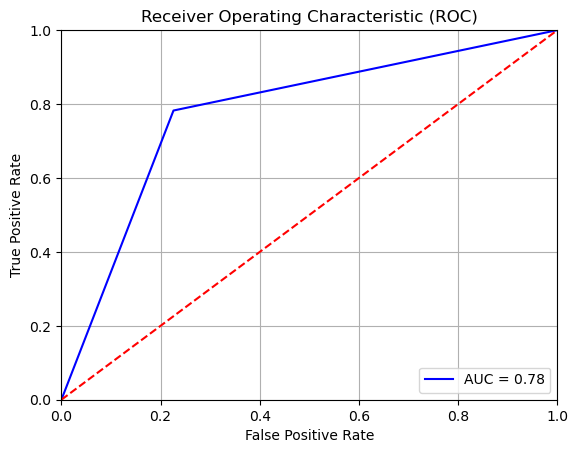

In [54]:
trainer.test()

#### Store Model

In [55]:
# If you like to store the model, uncomment the following lines and enter filename and path 
#filename = "model.pt"
#path = ROOT_PATH
#save_model(model, path + "/" + filename)

## Make predicitions

Use you the previously trained model to make prediction on some samples. At the end one can input a custom question pair and see how the model is performing on it.

#### Checkout random sample from training data

In [57]:
ind = 6
test_sample_train = dict()
for idx, batch in enumerate(train_dataloader):
    if idx == ind:
        test_sample_train['q1_text'] = [batch['q1_text'][0]]
        test_sample_train['q2_text'] = [batch['q2_text'][0]]
        test_sample_train['q1_token'] = [batch['q1_token'][0]]
        test_sample_train['q2_token'] = [batch['q2_token'][0]]
        test_sample_train['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_train['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_train['labels'] = [batch['labels'][0]]

trainer.predict(test_sample_train)

question 1: ['how do i start coding in c']
question 2: ['where should i start learning c']
tokens  q1: [[10, 18, 12, 74, 3412, 30, 814]]
tokens  q2: [[181, 167, 12, 74, 946, 814]]


Model predicts 1.0 --> Actual value 1.0
Model prediction is correct :)

The questions ['how do i start coding in c'] and ['where should i start learning c'] are similar!


#### Checkout random sample from validation data

In [58]:
ind = np.random.choice(len(val_dataloader))

test_sample_val = dict()
for idx, batch in enumerate(val_dataloader):
    if idx == ind:
        test_sample_val['q1_text'] = [batch['q1_text'][0]]
        test_sample_val['q2_text'] = [batch['q2_text'][0]]
        test_sample_val['q1_token'] = [batch['q1_token'][0]]
        test_sample_val['q2_token'] = [batch['q2_token'][0]]
        test_sample_val['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_val['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_val['labels'] = [batch['labels'][0]]

trainer.predict(test_sample_val)

question 1: ['why are indians racists']
question 2: ['how severe is racism in india']
tokens  q1: [[69, 2, 3377, 18113]]
tokens  q2: [[10, 5680, 22, 8168, 30, 176]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['why are indians racists'] and ['how severe is racism in india'] are dissimilar!


### Predict from custom input questions

In [59]:
default = True  # set to False to create your own inputs
similar = False  # select False to dispaly dissimlar example

if default:
    if similar:
        q1 = ['Is it cold today?']
        q2 = ['Will it be cold today?']
        label = [1.0]
    else:
        q1 = ['Will I pass the final?']
        q2 = ['What will I have for dinner tonight?']
        label = [0.0]
else:
    q1 = input(r'Enter your 1^st question: ')
    q2 = input(r'Enter your 2^nd question: ')
    label = input('label: ') # 0 for dissimilar, 1 for similar 
    q1 = [q1]
    q2 = [q2]
    label = [label]

In [60]:
# prepair custom input
# create df
df_own = pd.DataFrame(list(zip(q1, q2, label)), columns=['question1', 'question2', 'is_duplicate'])
# prepare data 
q_pair_own, label = convert_data_to_tuples(df_own, hparams['remove_stopwords'], hparams['stem_words'])
print(q_pair_own)

# create dataset 
own_dataset = QuoraDataset(q_pair_own, language.word2index, label)

# create dataloader
predict_dataloader = torch.utils.data.DataLoader(own_dataset, batch_size=1, collate_fn=collate)

for sample in predict_dataloader:
    test_sample = sample

# predict 
trainer.predict(test_sample)

Question Pairs:  1
[('will i pass the final', 'what will i have for dinner tonight')]
question 1: ['will i pass the final']
question 2: ['what will i have for dinner tonight']
tokens  q1: [[41, 12, 1487, 23, 1303]]
tokens  q2: [[1, 41, 12, 165, 63, 4425, 11626]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['will i pass the final'] and ['what will i have for dinner tonight'] are dissimilar!


## Important Demonstrations

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download wordnet data if it's your first time using NLTK lemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    # Convert the POS tagging output of NLTK to a format that the WordNetLemmatizer can understand
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_sentence(sentence):
    # Tokenize the sentence into words
#     words = nltk.word_tokenize(sentence)
    words = sentence.split()  # This both are same
    print(words)
    # Get the POS tagging of the words
    pos_tags = nltk.pos_tag(words)
    print(pos_tags)
    # Lemmatize the words with their POS tagging
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in pos_tags]
    print(lemmatized_words)
    # Join the lemmatized words back into a sentence
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence

# Example usage
sentence = "The quick brown foxes are jumping over the lazy dogs"
lemmatized_sentence = lemmatize_sentence(sentence)
print(lemmatized_sentence)  # Output: "The quick brown fox be jump over the lazy dog"

['The', 'quick', 'brown', 'foxes', 'are', 'jumping', 'over', 'the', 'lazy', 'dogs']
[('The', 'DT'), ('quick', 'JJ'), ('brown', 'NN'), ('foxes', 'NNS'), ('are', 'VBP'), ('jumping', 'VBG'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dogs', 'NNS')]
['The', 'quick', 'brown', 'fox', 'be', 'jump', 'over', 'the', 'lazy', 'dog']
The quick brown fox be jump over the lazy dog


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mustu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mustu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
text = "I am mustafa namliwala"
text.split()

['I', 'am', 'mustafa', 'namliwala']

In [45]:
stops = set(stopwords.words("english"))
# stops
# here not , no, nor are also stopwords which can completely change the sentiment of the sentence

In [94]:
lis = [5,9,8,2,3,7,1,10,100,88]

In [101]:
a = np.argsort(lis)
a

array([6, 3, 4, 0, 5, 2, 1, 7, 9, 8], dtype=int64)

In [98]:
np.sort(lis)

array([  1,   2,   3,   5,   7,   8,   9,  10,  88, 100])

In [103]:
for i in a:
    print(lis[i])

1
2
3
5
7
8
9
10
88
100


In [ ]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence

# Suppose we have the following padded batch of sequences:
seqs = torch.tensor([
    [1, 2, 3, 4, 5],  # length: 5
    [6, 7, 8, 0, 0],  # length: 3, padded with zeros
    [9, 10, 0, 0, 0]  # length: 2, padded with zeros
], dtype=torch.float)

lengths = torch.tensor([5, 3, 2])  # Lengths of the sequences before padding

# Packing the padded sequences
packed_seqs = pack_padded_sequence(seqs, lengths, batch_first=True, enforce_sorted=False)

# Now, packed_seqs is a PackedSequence object with two fields: .data and .batch_sizes
print(packed_seqs.data)
# Output: tensor([1., 6., 9., 2., 7., 10., 3., 8., 4., 5.])

print(packed_seqs.batch_sizes)
# Output: tensor([3, 3, 2, 1, 1])